In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rnd
import warnings,datetime,os,calendar,csv,time

import pickle,h5py,json

import tensorflow as tf
import pandas as pd
import seaborn as sns

from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Conv2D,Dropout,BatchNormalization,Input,Concatenate,Add,Activation,MaxPooling2D,AveragePooling2D
import keras.backend as K

from sklearn import preprocessing as pp
from sklearn.cluster import KMeans,DBSCAN,MeanShift,AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from statsmodels.tsa.seasonal import seasonal_decompose

from ipywidgets import interact

sns.set()
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
class SimilarityEncoder:
    
    from nltk.util import ngrams
    def __init__(self,n=3):
        self.fitted = False
        self.n = n
        
        self.nlist = []
        self.corpus = []
        
        self.M = np.empty(shape=[1,1])
        
    def fit(self,corpus):
        self.corpus = corpus
        for w in self.corpus:
            for k in ngrams(w,n=self.n):
                self.nlist.append(k)
        self.nlist = [''.join(k) for k in set(self.nlist)]
        
        self.M = np.zeros(shape=[len(self.corpus),len(self.nlist)])
        for p in self.corpus:
            for w in self.nlist:
                if w in [''.join(k) for k in ngrams(p,n=self.n)]: 
                    self.M[self.corpus.index(p),self.nlist.index(w)] = 1
        self.fitted = True
        return
    
    def transform(self,phrase):
        assert self.fitted,'Encoder has to be fitted before using it, please call the <SimilarityEncoder.fit> method first.'
        v = np.zeros(shape=[len(self.nlist)])
        for w in self.nlist:
            if w in [''.join(k) for k in ngrams(phrase.lower(),n=self.n)]:
                v[self.nlist.index(w)] = 1
        r = np.dot(self.M,v)
        rf = pd.DataFrame(index=self.corpus,columns=['Similarity'])
        rf['Similarity'] = r/len(list(ngrams(phrase.lower(),n=self.n)))
        return rf.sort_values(by=['Similarity'],ascending=False)

In [4]:
bf = pd.read_excel('..\\..\\TF_data\\ADMIN\\01\\20191003.xlsx')

bf['Buchungstag'] = pd.to_datetime(bf['Buchungstag'],format='%d.%m.%y')
bf['Valutadatum'] = pd.to_datetime(bf['Valutadatum'],format='%d.%m.%y')

In [5]:
bf

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Glaeubiger ID,Mandatsreferenz,Kundenreferenz (End-to-End),Sammlerreferenz,Lastschrift Ursprungsbetrag,Auslagenersatz Ruecklastschrift,Beguenstigter/Zahlungspflichtiger,Kontonummer/IBAN,BIC (SWIFT-Code),Betrag,Waehrung,Info
0,DE98773501100020557849,2019-09-30,2019-10-01,ABSCHLUSS,Abrechnung 30.09.2019 siehe Anlage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20557849,77350110,0.00,EUR,Umsatz gebucht
1,DE98773501100020557849,2019-09-30,2019-10-01,ENTGELTABSCHLUSS,Entgeltabrechnung siehe Anlage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,77350110,-4.50,EUR,Umsatz gebucht
2,DE98773501100020557849,2019-09-30,2019-09-30,DAUERAUFTRAG,"Miete fuer Haesschen, du bist toll :)",NaN,NaN,NaN,NaN,NaN,NaN,Elaine Fernandez,DE46763500000044116613,BYLADEM1ERH,-235.00,EUR,Umsatz gebucht
3,DE98773501100020557849,2019-09-30,2019-09-30,FOLGELASTSCHRIFT,V-Nr. 47589 09-19 Beitrag 24.90,DE55ZZZ00000122751,1e24299e271c466393f4127c29acca16,118-47589,NaN,NaN,NaN,SLF Sportland Franken GmbH & Co. KG,DE88763500000000062725,BYLADEM1ERH,-24.90,EUR,Umsatz gebucht
4,DE98773501100020557849,2019-09-30,2019-09-30,FOLGELASTSCHRIFT,300919 15194815 610971995391 SIEMENS CASINO CA...,DE2499700000150275,79977997OPA0000000000000320904,20190914616254176,NaN,NaN,NaN,Siemens Aktiengesellschaft,DE53700700100203008800,DEUTDEMMXXX,-66.89,EUR,Umsatz gebucht
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,DE98773501100020557849,2019-06-04,2019-06-04,FOLGELASTSCHRIFT,D01-7024908-5090217 Prime Video 46MBH24MG8R9STAW,DE96ZZZ00000594888,oc37jPPdyn(18.Jnwk(4ZmqelPv?vb,46MBH24MG8R9STAW,NaN,NaN,NaN,AMAZON INSTANT VIDEO GERMANY GMBH,DE07300308800013011001,TUBDDEDDXXX,-3.99,EUR,Umsatz gebucht
130,DE98773501100020557849,2019-06-04,2019-06-04,FOLGELASTSCHRIFT,D01-2458316-5317464 Prime Video 1JR4OX80IU4ZK5LZ,DE96ZZZ00000594888,oc37jPPdyn(18.Jnwk(4ZmqelPv?vb,1JR4OX80IU4ZK5LZ,NaN,NaN,NaN,AMAZON INSTANT VIDEO GERMANY GMBH,DE07300308800013011001,TUBDDEDDXXX,-3.99,EUR,Umsatz gebucht
131,DE98773501100020557849,2019-06-04,2019-06-04,FOLGELASTSCHRIFT,D01-3694464-4872643 Prime Video 43YYC08FGLD26R5H,DE96ZZZ00000594888,oc37jPPdyn(18.Jnwk(4ZmqelPv?vb,43YYC08FGLD26R5H,NaN,NaN,NaN,AMAZON INSTANT VIDEO GERMANY GMBH,DE07300308800013011001,TUBDDEDDXXX,-3.99,EUR,Umsatz gebucht
132,DE98773501100020557849,2019-06-03,2019-06-03,KARTENZAHLUNG,2019-06-01T11:40 Debitk.5 2021-12,NaN,NaN,56023048203931998163566592,NaN,NaN,NaN,REWE SAGT DANKE. 46659170//Erlangen/DE,DE41300500000001484310,WELADEDDXXX,-71.90,EUR,Umsatz gebucht


In [5]:
df = bf[['Buchungstag','Valutadatum','Buchungstext','Verwendungszweck','Beguenstigter/Zahlungspflichtiger','Kontonummer/IBAN','Betrag']].rename(columns={
    'Valutadatum':'Date', 
    'Buchungstag':'Date_booked', 
    'Buchungstext':'Text', 
    'Verwendungszweck':'Use',
    'Beguenstigter/Zahlungspflichtiger':'CONTACT', 
    'Kontonummer/IBAN':'AccNum', 
    'Betrag':'Value'
})

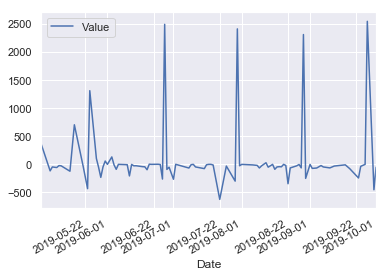

In [6]:
df[['Date','Value']].groupby(['Date']).sum().plot()

In [7]:
idx = pd.date_range(df['Date'].min(),df['Date'].max())

In [8]:
df0 = df[['Date','Value']].groupby(['Date']).sum().reindex(idx,fill_value=0)

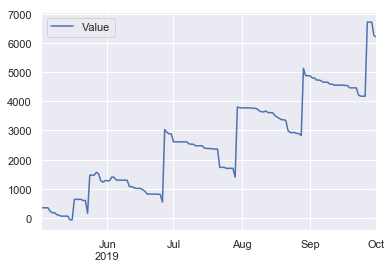

In [9]:
df0.cumsum().plot()

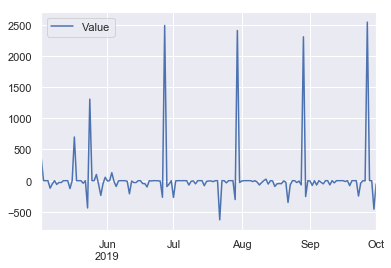

In [10]:
df0.plot()

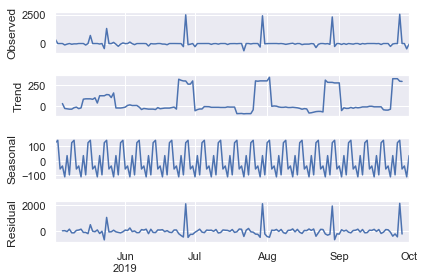

In [11]:
seasonal_decompose(df0).plot()
plt.show()

In [12]:
df1 = df[['Date','Text','CONTACT','AccNum','Value']]
df1['Count'] = 1

In [13]:
df2 = df1[['CONTACT','Count','Value']].groupby(['CONTACT']).sum().sort_values(by='Count',ascending=False).reset_index()

In [14]:
recurrent_labels = [
    'Siemens BKK',
    'ESTW-ERLANGERSTADTWERKEAG',
    'JENS MOELLER GMBH',
    'Siemens Aktiengesellschaft',
    'Siemens AG',
    'SLF Sportland Franken GmbH & Co. KG',
    'M-net Telekommunikations GmbH',
    'Telekom Deutschland GmbH                                              Landgrabenweg 151',
    'SCHAEFER NOHE SAGT DANKE//ERLANGEN/DE',
    'IGM Erlangen',
    'Elaine Fernandez'
]

df3 = df[df['CONTACT'].apply(lambda x: str(x) in recurrent_labels)]
df3['Count'] = 1

df_recurring = df3[['CONTACT','Value']].groupby(['CONTACT']).mean()
df_recurring['Count'] = df3[['CONTACT','Count']].groupby(['CONTACT']).sum()['Count']
df_recurring['TotalValue'] = df3[['CONTACT','Value']].groupby(['CONTACT']).sum()

df_recurring = df_recurring.sort_values(by=['TotalValue'])

In [15]:
shopping_labels = [
    'KARSTADT LEBENSM. SAGT DANK//Nuernberg Lorenz/DE',
    'REWE SAGT DANKE. 46659170//Erlangen/DE',
    'ALDI GMBH + CO. KG//ERLANGEN/DE',
    'NETTO MARKEN-DISCOU.',
    'Kaufland Erlangen//Erlangen/DE',
    'tegut... gute Lebensmittel GmbH + Co. KG',
    'XXXS006XXX SATURN E//NUERNBERG/DE',
    'DM FIL.1323 H:65239//ERLANGEN/DE',
    'Tiger Deutschland GmbH//Erlangen/DE/0'
]

entertainment_labels = [
    'Frisoer Klier 1283//Erlangen/DE',
    'L Osteria Erlangen//Erlangen/DE',
    'YORMA S AG//PLATTLING/DE',
    'Mr. Bleck//Erlangen/DE/0',
    'NBG HBF DUNKIN DONUTS//Nuernberg/DE',
    'AMAZON INSTANT VIDEO GERMANY GMBH'
]

excluded_labels = [
    'Angelika Deinhard',
    'DEINHARD FRANZ U BRI',
    'ELAINE FERNANDEZ',
    'Hermann Kuespert',
    'DekaBank Deutsche Girozentrale                                        Mainzer Landstr. 16',
    'ESTW - ERLANGER STADTWERKE AG'
]

df4 = df[df['CONTACT'].apply(lambda x: str(x) not in recurrent_labels)]

df4 = df4.drop(index=df4[df4['CONTACT'].apply(lambda x: str(x) in excluded_labels)].index)

df4['CONTACT'] = df4['CONTACT'].apply(lambda x: 'SPARKASSE' if 'sparkasse' in str(x).lower() else x)
df4['CONTACT'] = df4['CONTACT'].apply(lambda x: 'SHOPPING' if str(x) in shopping_labels else x)
df4['CONTACT'] = df4['CONTACT'].apply(lambda x: 'ENTERTAINMENT' if str(x) in entertainment_labels else x)

df4['Count'] = 1

df_singular = df4[['CONTACT','Value']].groupby(['CONTACT']).mean()
df_singular['Count'] = df4[['CONTACT','Count']].groupby(['CONTACT']).sum()['Count']
df_singular['TotalValue'] = df4[['CONTACT','Value']].groupby(['CONTACT']).sum()

df_singular = df_singular.sort_values(by=['TotalValue'])

In [16]:
df_recurring

,Value,Count,TotalValue
CONTACT,,,
Elaine Fernandez,-235.000,5,-1175.00
SCHAEFER NOHE SAGT DANKE//ERLANGEN/DE,-79.800,5,-399.00
Telekom Deutschland GmbH Landgrabenweg 151,-61.526,5,-307.63
Siemens Aktiengesellschaft,-71.110,4,-284.44
JENS MOELLER GMBH,-69.000,4,-276.00
ESTW-ERLANGERSTADTWERKEAG,-64.500,4,-258.00
M-net Telekommunikations GmbH,-29.900,5,-149.50
Siemens BKK,-70.540,2,-141.08
SLF Sportland Franken GmbH & Co. KG,-24.900,5,-124.50


In [17]:
df_singular

,Value,Count,TotalValue
CONTACT,,,
KREDITKARTENABRECHNUNG,-309.496667,6,-1856.98
SPARKASSE,-42.380952,21,-890.00
SHOPPING,-32.925385,13,-428.03
ENTERTAINMENT,-6.115217,46,-281.30
"PayPal (Europe) S.a.r.l. et Cie., S.C.A.",-21.082000,10,-210.82
GA NR00002630 BLZ77350110 5,-30.000000,1,-30.00


In [18]:
df_singular

,Value,Count,TotalValue
CONTACT,,,
KREDITKARTENABRECHNUNG,-309.496667,6,-1856.98
SPARKASSE,-42.380952,21,-890.00
SHOPPING,-32.925385,13,-428.03
ENTERTAINMENT,-6.115217,46,-281.30
"PayPal (Europe) S.a.r.l. et Cie., S.C.A.",-21.082000,10,-210.82
GA NR00002630 BLZ77350110 5,-30.000000,1,-30.00


In [182]:
df5 = df[['Date','Value','CONTACT']].copy()

df5['CONTACT'] = df5['CONTACT'].apply(lambda x: 'SPARKASSE' if 'sparkasse' in str(x).lower() else x)
df5['CONTACT'] = df5['CONTACT'].apply(lambda x: 'SHOPPING' if str(x) in shopping_labels else x)
df5['CONTACT'] = df5['CONTACT'].apply(lambda x: 'ENTERTAINMENT' if str(x) in entertainment_labels else x)

df5 = df5.groupby(['CONTACT','Date']).sum().reset_index()

df5['Freq'] = np.nan
for contact_name in df5['CONTACT'].unique().tolist():
    n_months = (df5[df5['CONTACT']==contact_name]['Date'].max()-df5[df5['CONTACT']==contact_name]['Date'].min())/np.timedelta64(1,'M')
    n_contacts = df5[df5['CONTACT']==contact_name].shape[0]
    if n_months>0: df5.ix[df5[df5['CONTACT']==contact_name].index,'Freq'] = n_contacts/n_months

In [289]:
df5 = df5.dropna().reset_index(drop=True)

In [290]:
df5['Scaled Value'] = np.sign(df5['Value'])*np.log(df5['Value'].abs())

In [291]:
km = KMeans()
df5['KM Class'] = km.fit(df5[['Scaled Value','Freq']].values).labels_+1

In [292]:
dbscan = DBSCAN()
df5['DBSCAN Class'] = dbscan.fit(df5[['Scaled Value','Freq']].values).labels_+1

In [293]:
ms = MeanShift()
df5['MS Class'] = ms.fit(df5[['Scaled Value','Freq']].values).labels_+1

In [294]:
agg = AgglomerativeClustering()
df5['Agg Class'] = agg.fit(df5[['Scaled Value','Freq']].values).labels_+1

In [295]:
gmm = GaussianMixture(n_components=6)
df5['GMM Class'] = gmm.fit_predict(df5[['Scaled Value','Freq']].values)+1

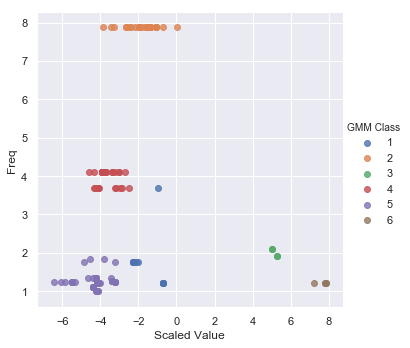

In [296]:
sns.lmplot(x='Scaled Value',y='Freq',data=df5,hue='GMM Class',fit_reg=False)

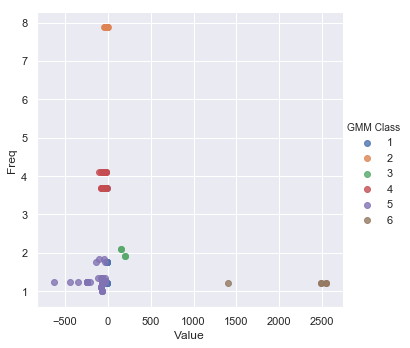

In [297]:
sns.lmplot(x='Value',y='Freq',data=df5,hue='GMM Class',fit_reg=False)

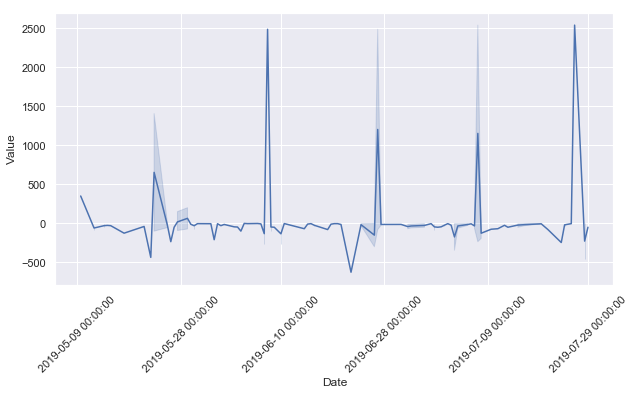

In [298]:
df6 = df5[['Date','Value','GMM Class']].groupby(['GMM Class','Date']).sum().reset_index()

g = plt.figure(figsize=(10,5))
g = sns.lineplot(x='Date',y='Value',data=df6)
g.set_xticklabels(df6['Date'],rotation=45)

plt.show()

In [321]:
action_dict = {
    'Daily Casual Exp.':4,
    'Ordinary Revenue':6,
    'Entertainment Exp.':2,
    'Monthly Recurring Exp.':5,
    'Miscellaneous Casual Exp.':1,
    'Extraordinary Revenue':3
}

@interact(Class=['Daily Casual Exp.','Ordinary Revenue','Entertainment Exp.','Monthly Recurring Exp.','Miscellaneous Casual Exp.','Extraordinary Revenue'])
def plot(Class):
    cls = action_dict[Class]
    c_df = df6[df6['GMM Class']==cls][['Date','Value']].set_index(['Date']).reindex(idx,fill_value=0).reset_index().rename(columns={'index':'Date'})
    g = plt.figure(figsize=(10,5))
    g = sns.lineplot(x='Date',y='Value',data=c_df)
    g.set_xticklabels(c_df['Date'],rotation=45)

interactive(children=(Dropdown(description='Class', options=('Daily Casual Exp.', 'Ordinary Revenue', 'Enterta…